In [1]:
# 1. 데이터 확보
import zipfile
filepath = 'data/glaucoma.zip'
with zipfile.ZipFile(filepath, 'r') as f:
    f.extractall('data/')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rotation_range=20, # 최대 회전 각도
    width_shift_range=0.2, # 가로 방향 -20%~20% 이동 정도
    height_shift_range=0.2, # 상하 방향 이동 정도
    horizontal_flip=True, # 수평뒤집기
    vertical_flip=True,) # 수직뒤집기
train_data = train_generator.flow_from_directory(
    'data/glaucoma/train',
    target_size=(224,224),
    batch_size=4,
    class_mode='sparse' # 종속변수에 원핫인코딩 안 함
)
test_generator = ImageDataGenerator()
test_data = test_generator.flow_from_directory(
    'data/glaucoma/test',
    target_size=(224,224),
    batch_size=4,
    class_mode='sparse'
)

Found 828 images belonging to 3 classes.
Found 320 images belonging to 3 classes.


In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
import numpy as np
from tensorflow.keras.models import Sequential # ResNet50의 Dense층에 사용자 추가
from tensorflow.keras.layers import Flatten, Dense
import matplotlib.pyplot as plt
import cv2 # 이미지를 넘파이로 읽어오기

In [4]:
# 모델구성
resnet_model = ResNet50(
    input_shape=(224,224,3),
    include_top=False,) # 컨볼루션과 폴링 레이어만
resnet_model.trainable=True

In [5]:
# model = Sequential()
# model.add(resnet_model)
# model.add(Flatten())
# model.add(Dense(units=1024, activation='relu'))
# model.add(Dense(units=3, activation='softmax'))
model = Sequential([
    resnet_model,
    Flatten(),
    Dense(units=512,activation='relu'),
    Dense(units=3, activation='softmax')
])

model.summary()

# 학습 시 필요한 용량
# 1. 파라미터 사용 메모리 사용량 : 126,352,259 * 4 byte / 1024의 제곱 = 482MB
# 2. 배치사이즈=3일 경우 3*(224*224*4)*4 byte / 1024의 제곱 = 19MB
# 각 layer층 마다 활성화 값

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 74,969,987
Trainable params: 74,916,867
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
# 모델 학습 설정
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 모델 학습
model.fit(train_data, epochs=20, validation_data=test_data, batch_size=1)

Epoch 1/20
207/207 [==============================] - 37s 143ms/step - loss: 8.8023 - accuracy: 0.6027 - val_loss: 375.5107 - val_accuracy: 0.1656
Epoch 2/20
207/207 [==============================] - 29s 139ms/step - loss: 0.9125 - accuracy: 0.6135 - val_loss: 2.6814 - val_accuracy: 0.6438
Epoch 3/20
207/207 [==============================] - 29s 139ms/step - loss: 0.6868 - accuracy: 0.6763 - val_loss: 1.5422 - val_accuracy: 0.6687
Epoch 4/20
207/207 [==============================] - 29s 139ms/step - loss: 0.6240 - accuracy: 0.6836 - val_loss: 2.6049 - val_accuracy: 0.6656
Epoch 5/20
207/207 [==============================] - 29s 139ms/step - loss: 0.6473 - accuracy: 0.7041 - val_loss: 3.9386 - val_accuracy: 0.6500
Epoch 6/20
207/207 [==============================] - 29s 139ms/step - loss: 0.6196 - accuracy: 0.7150 - val_loss: 3.1001 - val_accuracy: 0.6562
Epoch 7/20
207/207 [==============================] - 29s 139ms/step - loss: 0.5935 - accuracy: 0.7331 - val_loss: 4.2570 - val_

In [26]:
# 평가하기
model.evaluate(test_data)

80/80 [==============================] - 3s 35ms/step - loss: 1.9262 - accuracy: 0.6938


[1.9262069463729858, 0.6937500238418579]

1/1 [==============================] - 0s 40ms/step
[[1.3804147e-01 8.6181110e-01 1.4743657e-04]]
1


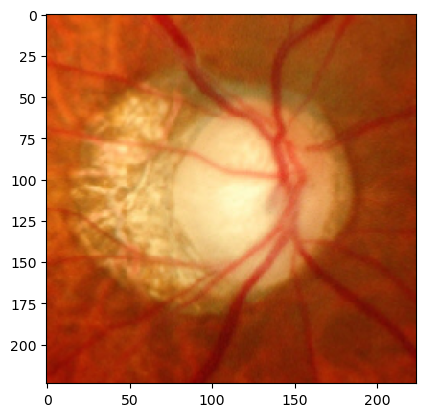

In [25]:
# 예측하기
test_img = cv2.imread('data/test.png', cv2.IMREAD_ANYCOLOR) # BGR포맷 넘파이
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, dsize=(224,224), interpolation=cv2.INTER_AREA)
test_img = test_img.reshape(-1,224,224,3)
pred = model.predict(test_img)
print(pred)
print(pred.argmax())
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 28ms/step
[[2.0092212e-01 7.9880220e-01 2.7567215e-04]]
1


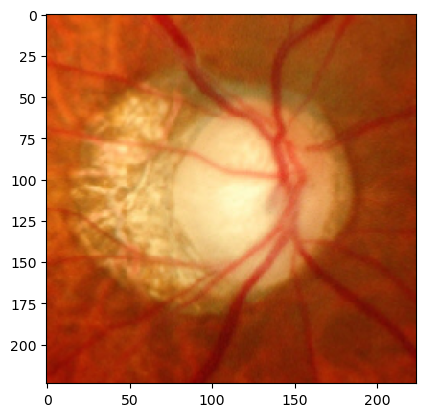

In [24]:
img = image.load_img('data/test.png', target_size=(224,224))
x = image.img_to_array(img).reshape(-1,224,224,3)
pred = model.predict(x)
print(pred)

print(pred.argmax())
plt.imshow(img)
plt.show()